In [155]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import os
from progressbar import progressbar as pbar
from earthtext.osm import osm
from joblib import delayed, Parallel
import sys

# gather all areas and lengths of all tags

In [27]:
osm_folder = "/opt/data/california-naip-chips/osm"

In [28]:
osm_files = os.listdir(osm_folder)
len(osm_files)

113160

In [40]:
class mParallel(Parallel):
    """
    substitutes joblib.Parallel with richer verbose progress information
    """
    def _print(self, msg):
        if self.verbose > 10:
            fmsg = '[%s]: %s' % (self, msg)
            sys.stdout.write('\r ' + fmsg)
            sys.stdout.flush()

In [83]:
def get_tag_stats(osm_file):
    tag_stats = {}
    z = gpd.read_parquet(f"{osm_folder}/{osm_file}")
    for _,row in z.iterrows():
        tags = tags if type(row.tags)==dict else eval(row.tags)
        for k,v in tags.items():
            t = f"{k}={v}"
            if not t in tag_stats.keys():
                tag_stats[t] = {'areas': [], 'lengths': []}
            tag_stats[t]['areas'].append(row['area'])
            tag_stats[t]['lengths'].append(row['length'])
    return tag_stats

In [84]:
r = mParallel(n_jobs=60, verbose=30)(delayed(get_tag_stats)(osm_file) for osm_file in osm_files)

 [mParallel(n_jobs=60)]: Done 113160 out of 113160 | elapsed:  1.3min finishedg:    0.1sh_size=8.

In [85]:
len(osm_files)

113160

In [86]:
r[0]

{'highway=track': {'areas': [0.0], 'lengths': [153.6865180999946]},
 'landuse=farmland': {'areas': [18671.535429628813],
  'lengths': [546.9192079617839]}}

In [191]:
consolidated_stats = {}
for ri in pbar(r):
    for k,v in ri.items():
        if not k in consolidated_stats.keys():
            consolidated_stats[k] = {'areas': [], 'lengths': [], 'counts': [] } 

        consolidated_stats[k]['areas'] = consolidated_stats[k]['areas'] + v['areas']
        consolidated_stats[k]['lengths'] = consolidated_stats[k]['lengths'] + v['lengths']
        consolidated_stats[k]['counts'].append(len(v['areas']))

100% (113160 of 113160) |################| Elapsed Time: 0:03:40 Time:  0:03:400218


In [192]:
len(r)

113160

# consider tags that appear in at least 100 chips

In [233]:
keys100 = [k for k in consolidated_stats.keys() if len(consolidated_stats[k]['counts'])>100]

In [235]:
consolidated_stats_k100 = {k:v for k, v in consolidated_stats.items() if k in keys100}
consolidated_stats_k100[

In [264]:
consolidated_stats_k100 = {}
for k, v in consolidated_stats.items():
    if k in keys100:
        consolidated_stats_k100[k] = v
        consolidated_stats_k100[k]['nchips'] = len(consolidated_stats_k100[k]['counts'])


In [271]:
cmeans = {k: {kk:(np.mean(vv) if kk!='nchips' else vv) for kk,vv in v.items()} for k,v in consolidated_stats_k100.items()}

In [278]:
pd.DataFrame(cmeans, index=['mean area', 'mean length', 'mean occurrences per chip', 'number of chips it appears']).T

,mean area,mean length,mean occurrences per chip,number of chips it appears
highway=track,NaN,NaN,NaN,NaN
landuse=farmland,NaN,NaN,NaN,NaN
power=tower,NaN,NaN,NaN,NaN
power=line,NaN,NaN,NaN,NaN
landuse=industrial,NaN,NaN,NaN,NaN
...,...,...,...,...
power=cable,NaN,NaN,NaN,NaN
natural=coastline,NaN,NaN,NaN,NaN
railway=light_rail,NaN,NaN,NaN,NaN
leisure=offroad_driving,NaN,NaN,NaN,NaN


In [286]:
s = pd.DataFrame(cmeans).T
s.columns=['mean area', 'mean length', 'mean occurrences per chip', 'number of chips it appears']
s.sort_index(inplace=True)
s

,mean area,mean length,mean occurrences per chip,number of chips it appears
aerodrome:type=public,19834.251312,558.852163,1.008403,119.0
aerospace:project=deep_space_network,22288.607797,597.125056,1.025597,586.0
aeroway=aerodrome,18395.658409,537.915086,1.032637,766.0
aeroway=apron,9053.262303,391.608342,1.056911,123.0
aeroway=runway,606.818775,135.670343,1.160920,174.0
...,...,...,...,...
waterway=ditch,204.581066,100.899189,1.257143,245.0
waterway=drain,0.064539,83.687807,1.433566,1001.0
waterway=pressurised,0.000000,99.995700,1.296029,277.0
waterway=river,0.000000,116.314065,1.039948,776.0


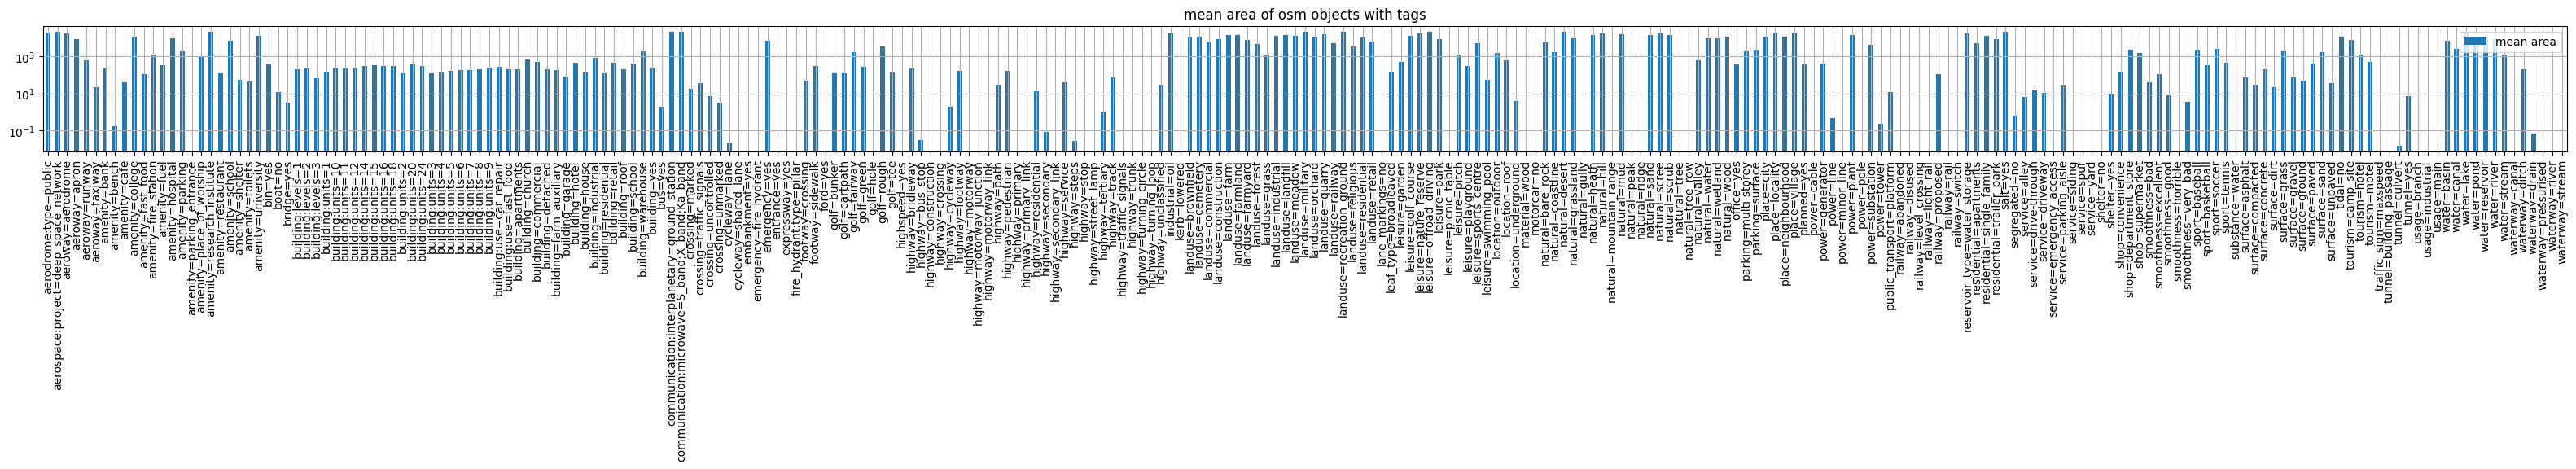

In [291]:
s[['mean area']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean area of osm objects with tags')
plt.yscale('log')


Text(0.5, 1.0, 'mean occurrences per chip')

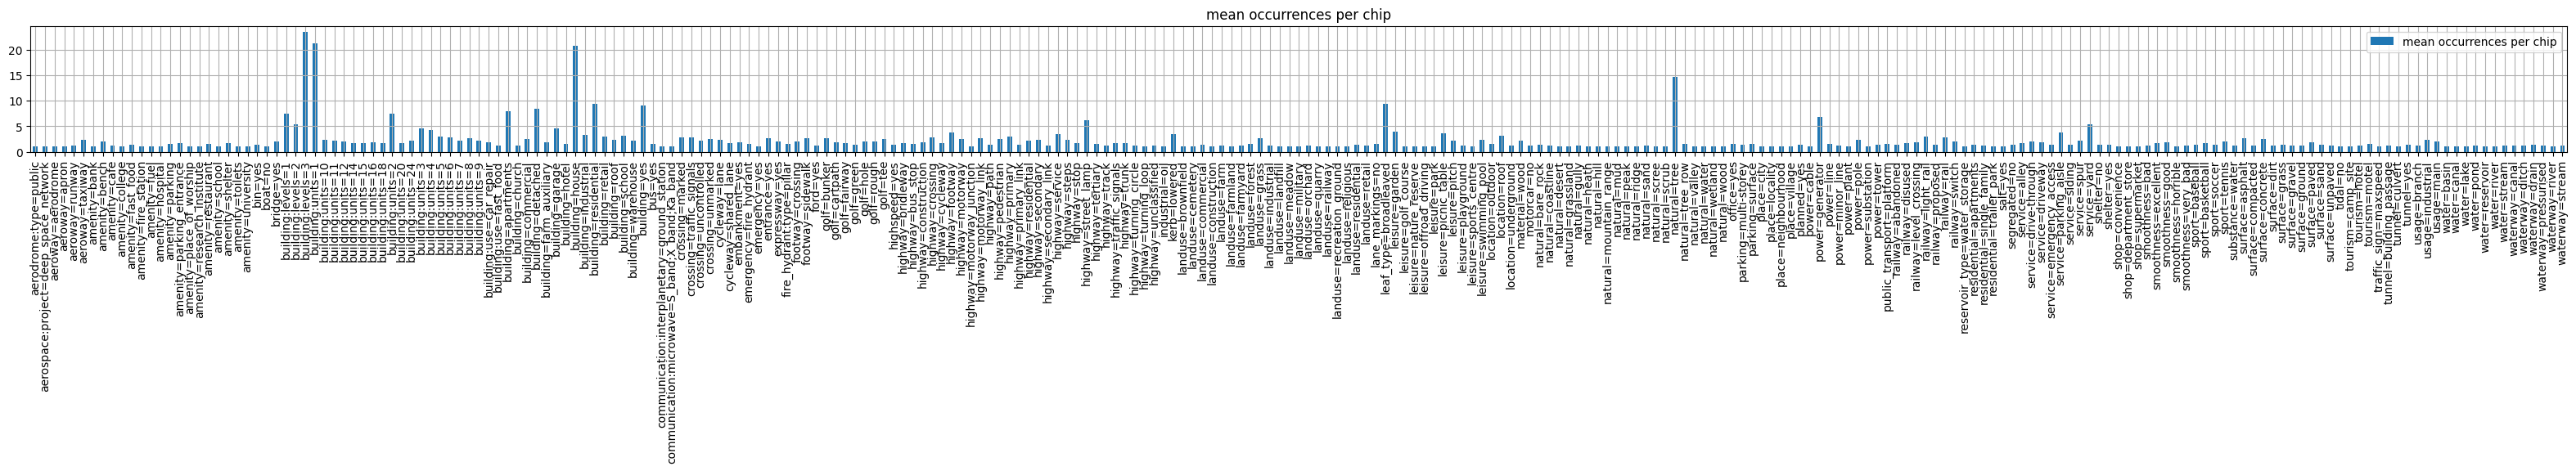

In [293]:
s[['mean occurrences per chip']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('mean occurrences per chip')

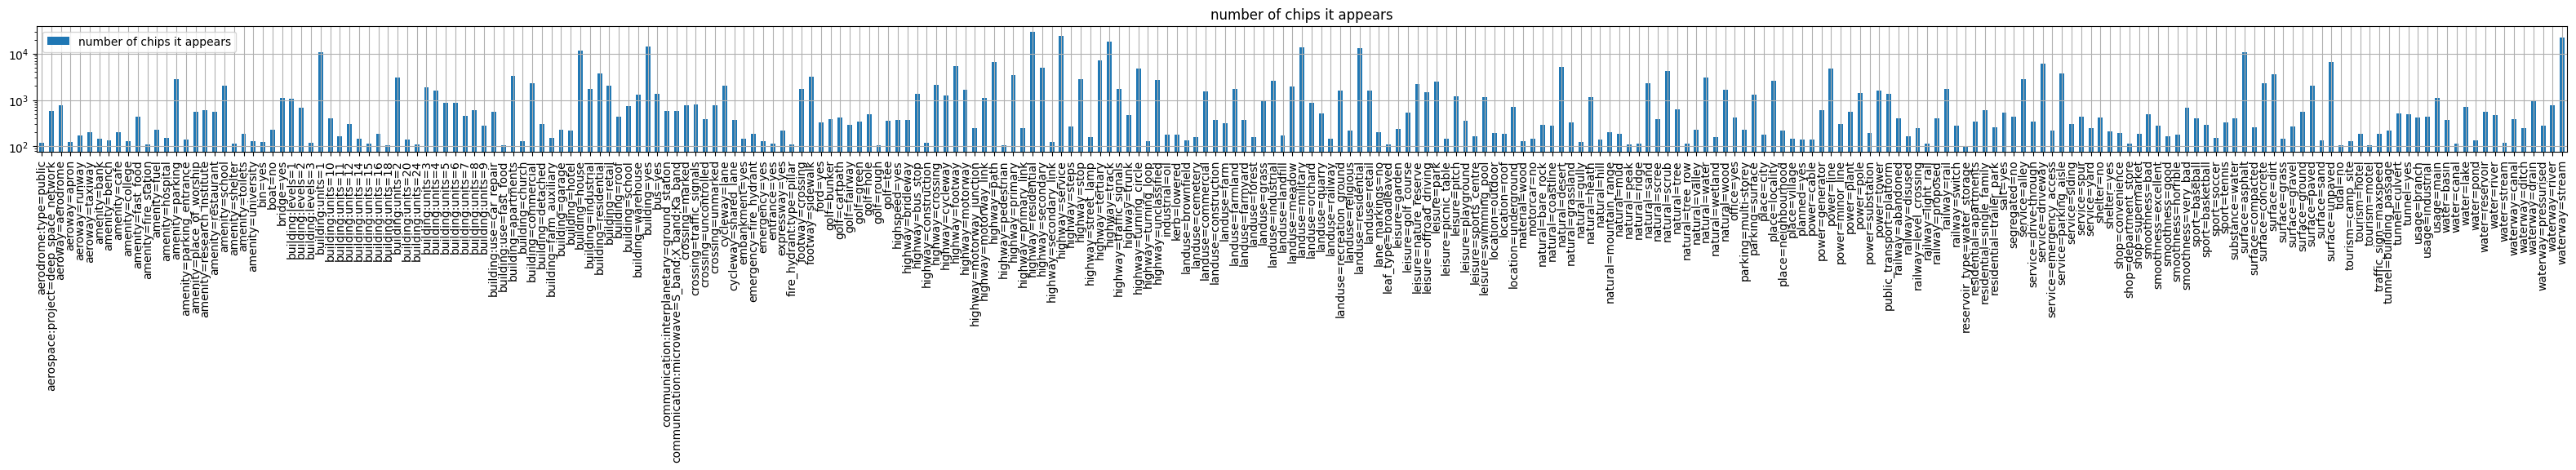

In [295]:
s[['number of chips it appears']].plot(kind='bar', figsize=(40,2))
plt.grid()
plt.title('number of chips it appears')
plt.yscale('log')
